<a href="https://colab.research.google.com/github/Rango-Zhang-Hang/AI6103-DEEP-LEARNING-APPLICATIONS/blob/main/Assignment2DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Installation of Libraries.
!pip install transformers
!pip install nlpaug
!pip install data
!pip install data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 64.6 MB/s 
     |████████████████████████████████| 7.6 MB 59.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7246 sha256=ff0b924f2ab477a73a277b3f4f4f5f890c79beb922d18a4d2a6c5b319edbf2aa
  Stored in directory: /root/.cache/pip/wheels/28/76/4b/7db27e02c1de4d2181559d108fcdfed1680ff7d3534553d460
Successfully built data
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


** Baseline codes ** 

In [2]:
import torch
#from transformers import *
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM
from transformers import AdamW, BertTokenizer, get_linear_schedule_with_warmup


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
## Import the dataset
from google.colab import files,drive
drive.mount('/content/drive/')  ## may require to changes the path location in git.
df2 = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')
df2

Mounted at /content/drive/


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
51569,I thought this movie did a down right good job...,positive
51570,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
51571,I am a Catholic taught in parochial elementary...,negative
51572,I'm going to have to disagree with the previou...,negative


In [5]:
df2['sentiment'] = df2['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df2.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


**Data Analysis** : Perform to understand the data 

In [6]:
#dataset dimensions
df2.shape

(51574, 2)

In [7]:
df2.columns

Index(['review', 'sentiment'], dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'sentiments')

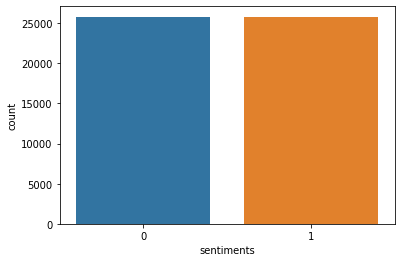

In [8]:
# Polarity Plots to see how many postive and negative
sns.countplot(df2.sentiment)
plt.xlabel('sentiments')

In [10]:
# Polarity counts
df2.sentiment.value_counts()

0    25819
1    25755
Name: sentiment, dtype: int64

In [11]:
## Check for null values in the columns  
df2.isnull().sum()

review       0
sentiment    0
dtype: int64

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51574 entries, 0 to 51573
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     51574 non-null  object
 1   sentiment  51574 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 806.0+ KB


In [14]:
df2

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
51569,I thought this movie did a down right good job...,1
51570,"Bad plot, bad dialogue, bad acting, idiotic di...",0
51571,I am a Catholic taught in parochial elementary...,0
51572,I'm going to have to disagree with the previou...,0


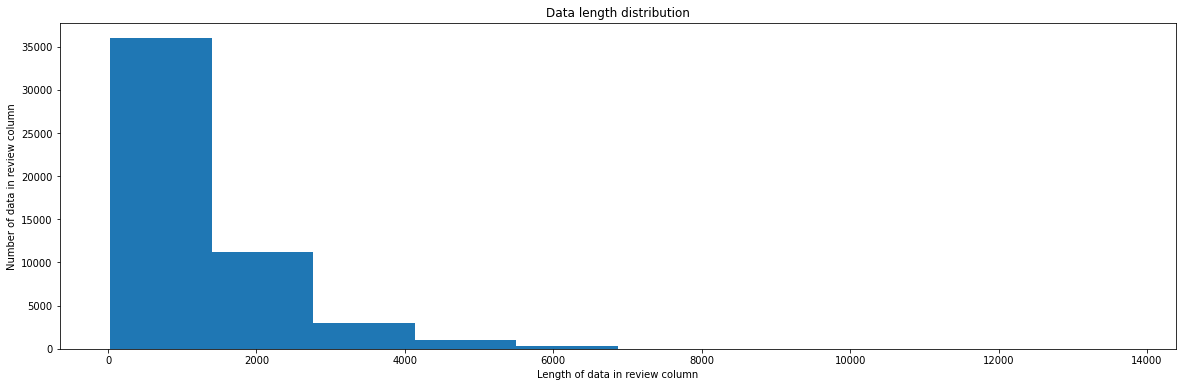

In [15]:
# Average number of words in review  
plt.figure(figsize=(20, 6))
plt.hist([len(n) for n in list(df2['review'])])
plt.xlabel('Length of data in review column')
plt.ylabel('Number of data in review column')
plt.title('Data length distribution')
plt.show()

**Cleansing  of Data **

In [16]:
import tensorflow as tf
import re

def cleansingtext(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    text=re.sub("\s\s+" , " ", text)
    text=text.lower()
    text= re.sub('<.*?##>', ' ', text)
    text= re.sub('\[[^]].()*\]', '', text)
    return text

def preprocess_review(text):
    clean_text = cleansingtext(text)
    return clean_text


In [17]:
df2["review"] = df2.review.apply(preprocess_review)


In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [19]:
# Load pre-trained model : 'bert-base-cased' tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME , return_dict=False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# Bertencoder Function ## Taking one from the records 
text = 'This a fantastic movie of three prisoners who become famous. One of the actors is george clooney \
and I am not a fan but this roll is not bad Another good thing about the movie is the soundtrack The man of constant sorrow I recommand this movie to everybody. Greetings Bart'

tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: This a fantastic movie of three prisoners who become famous. One of the actors is george clooney and I am not a fan but this roll is not bad Another good thing about the movie is the soundtrack The man of constant sorrow I recommand this movie to everybody. Greetings Bart
   Tokens: ['This', 'a', 'fantastic', 'movie', 'of', 'three', 'prisoners', 'who', 'become', 'famous', '.', 'One', 'of', 'the', 'actors', 'is', 'g', '##eor', '##ge', 'c', '##lo', '##oney', 'and', 'I', 'am', 'not', 'a', 'fan', 'but', 'this', 'roll', 'is', 'not', 'bad', 'Another', 'good', 'thing', 'about', 'the', 'movie', 'is', 'the', 'soundtrack', 'The', 'man', 'of', 'constant', 'sorrow', 'I', 're', '##com', '##mand', 'this', 'movie', 'to', 'everybody', '.', 'G', '##reet', '##ings', 'Bart']
Token IDs: [1188, 170, 14820, 2523, 1104, 1210, 5419, 1150, 1561, 2505, 119, 1448, 1104, 1103, 5681, 1110, 176, 25690, 2176, 172, 2858, 18066, 1105, 146, 1821, 1136, 170, 5442, 1133, 1142, 5155, 1110, 1136, 2213, 2543, 136

In [21]:
#Performing preprocessing 
encoding = tokenizer.encode_plus(
  text,
  max_length=32,
  add_special_tokens=True, 
  return_token_type_ids=False,
  pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

63


tensor([  101,  1188,   170, 14820,  2523,  1104,  1210,  5419,  1150,  1561,
         2505,   119,  1448,  1104,  1103,  5681,  1110,   176, 25690,  2176,
          172,  2858, 18066,  1105,   146,  1821,  1136,   170,  5442,  1133,
         1142,  5155,  1110,  1136,  2213,  2543,  1363,  1645,  1164,  1103,
         2523,  1110,  1103,  5945,  1109,  1299,  1104,  4836, 17359,   146,
         1231,  8178, 20993,  1142,  2523,  1106, 10565,   119,   144, 17399,
         5018, 13045,   102])

In [ ]:
#Attentions masked 
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

In [24]:
#Tokenized with BERT tokenizer
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'This',
 'a',
 'fantastic',
 'movie',
 'of',
 'three',
 'prisoners',
 'who',
 'become',
 'famous',
 '.',
 'One',
 'of',
 'the',
 'actors',
 'is',
 'g',
 '##eor',
 '##ge',
 'c',
 '##lo',
 '##oney',
 'and',
 'I',
 'am',
 'not',
 'a',
 'fan',
 'but',
 'this',
 'roll',
 'is',
 'not',
 'bad',
 'Another',
 'good',
 'thing',
 'about',
 'the',
 'movie',
 'is',
 'the',
 'soundtrack',
 'The',
 'man',
 'of',
 'constant',
 'sorrow',
 'I',
 're',
 '##com',
 '##mand',
 'this',
 'movie',
 'to',
 'everybody',
 '.',
 'G',
 '##reet',
 '##ings',
 'Bart',
 '[SEP]']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

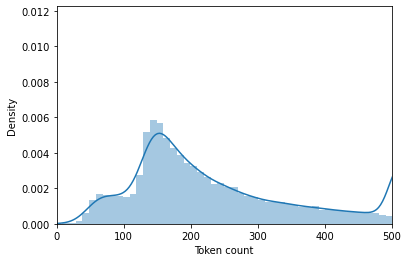

In [25]:
## Density VS Token Count
token_lens = []

for txt in df2.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 500]);
plt.xlabel('Token count')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


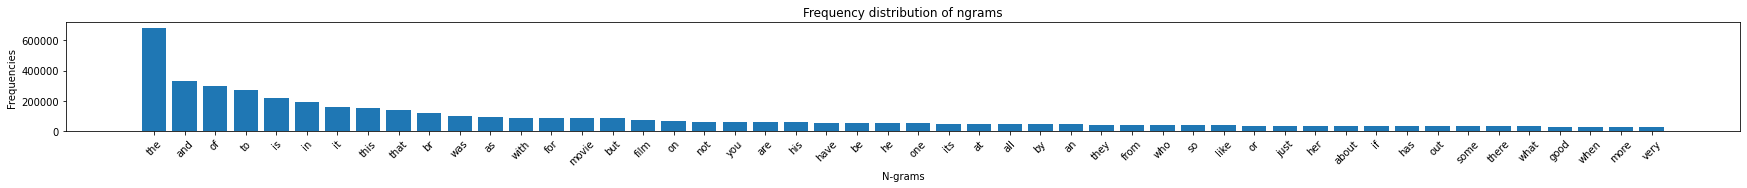

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] ('the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'or', 'just', 'her', 'about', 'if', 'has', 'out', 'some', 'there', 'what', 'good', 'when', 'more', 'very')


In [41]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectortext = vectorizer.fit_transform(list(df2['review']))
allngrams = vectorizer.get_feature_names()
num = min(50, len(allngrams))
all_counts = vectortext.sum(axis=0).tolist()[0]

allngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, allngrams), reverse=True)])
idx = np.arange(num)
ngrams = allngrams[:num]
countdata = all_counts[:num]

# Frequency distribution plot of the most seen words in the corpus.
plt.figure(figsize=(30, 2))
plt.bar(idx, countdata)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

print(idx, ngrams)




In [42]:
## Import Sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
ngram = (1, 2)
TOPlist = 10000
Min_Freq= 2

def ngram_function(texts, labels):
    kwargs = {
        'ngram_range' : ngram,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : 'word',
        'min_df' : Min_Freq,
    }
    #  Train data and vectorize train and val sets
    tfidf = TfidfVectorizer(**kwargs)
    texts = tfidf.fit_transform(texts)
    
    # Feature importance derived by f_classif to determine the best k-features
    result = SelectKBest(f_classif, k=min(TOPlist, texts.shape[1]))
    result.fit(texts, labels)
    texts = result.transform(texts).astype('float32')
    return texts
# Vectorize the data
vectordata = ngram_function(df2['review'], df2['sentiment'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:2032: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning,


In [43]:
vectordata.shape

(51574, 10000)

In [44]:
tfidf = TfidfVectorizer()
result_texts = tfidf.fit_transform(df2['review'])
result_texts.shape

(51574, 180746)

**Split the Data** 

In [45]:
MAX_LEN = 200      #for not consuming much resources
RANDOM_SEED = 42
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [46]:
#doing the split of the dataset into training, validation and testing sets
df_train, df_test = train_test_split(df2, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape

(46416, 2)

In [48]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long)
    }


In [49]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [50]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [51]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments'])

In [52]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['sentiments'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


**Reviews Classification with BERT and Hugging Face**


In [53]:
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np

In [54]:
class IMDBClassifier(nn.Module):

  def __init__(self, n_classes):
    super(IMDBClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME , return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)
    

In [55]:
model = IMDBClassifier(len(df2['sentiment'].unique()))
model = model.to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 200])
torch.Size([16, 200])


In [57]:
functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5767, 0.4233],
        [0.4427, 0.5573],
        [0.4880, 0.5120],
        [0.4492, 0.5508],
        [0.6709, 0.3291],
        [0.6193, 0.3807],
        [0.5135, 0.4865],
        [0.5975, 0.4025],
        [0.6380, 0.3620],
        [0.5273, 0.4727],
        [0.5667, 0.4333],
        [0.5783, 0.4217],
        [0.6223, 0.3777],
        [0.5934, 0.4066],
        [0.6329, 0.3671],
        [0.6510, 0.3490]], device='cuda:0', grad_fn=<SoftmaxBackward0>)



**Training (fine-tuning of BERT for classification task)**

In [58]:
def training_epoch(
  model, data_loader, loss_fun, optimizer, device, scheduler, example_n):
  model = model.train()

  losses = []
  predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fun(outputs, sentiments)

    predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return predictions.double() / example_n, np.mean(losses)

In [60]:
def evaluate_model(model, data_loader, loss_fun, device, example_n):
  model = model.eval()

  losses = []
  predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return predictions.double() / example_n, np.mean(losses)

In [62]:
EPOCHS = 10
#net = IMDBClassifier().to('cuda')
loss_fn = nn.CrossEntropyLoss().to('cuda')
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

train_acc = []
train_loss = []
val_acc = []
val_loss = []
best_accuracy = 0

for epoch in range(1,11):

  #print(f'Epoch {epoch + 1}')
  #print('-' * 10)
  train_acc_, train_loss_ = training_epoch(model,train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss_} accuracy {train_acc_}')
  val_acc_, val_loss_ = evaluate_model(model,val_data_loader,loss_fn, device, len(df_val))
  print(f'Val   loss {val_loss_} accuracy {val_acc_}')
  #print()
  print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.29267245989359636 accuracy 0.8796535677352637


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.24641031838585564 accuracy 0.9003489724699496
Epoch :   1, training loss : 0.2927, training accuracy : 0.88, val loss : 0.2464, val accuracy : 0.90


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.17379856516551084 accuracy 0.9462254395036195


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.35502177317781997 accuracy 0.9073284218689414
Epoch :   2, training loss : 0.1738, training accuracy : 0.95, val loss : 0.3550, val accuracy : 0.91


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.11500895631438432 accuracy 0.9716477076870045


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.453287447110698 accuracy 0.901899961225281
Epoch :   3, training loss : 0.1150, training accuracy : 0.97, val loss : 0.4533, val accuracy : 0.90


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.07550222731822773 accuracy 0.983453981385729


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5189427595584147 accuracy 0.9057774331136099
Epoch :   4, training loss : 0.0755, training accuracy : 0.98, val loss : 0.5189, val accuracy : 0.91


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.04955727785762335 accuracy 0.98963719407101


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5934878202172479 accuracy 0.9015122140364482
Epoch :   5, training loss : 0.0496, training accuracy : 0.99, val loss : 0.5935, val accuracy : 0.90


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.03777491424496833 accuracy 0.9924164081351259


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5978510162398222 accuracy 0.905389685924777
Epoch :   6, training loss : 0.0378, training accuracy : 0.99, val loss : 0.5979, val accuracy : 0.91


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.02536377652393565 accuracy 0.995044812133747


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.6625342401783672 accuracy 0.9084916634354401
Epoch :   7, training loss : 0.0254, training accuracy : 1.00, val loss : 0.6625, val accuracy : 0.91


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.015256339046209617 accuracy 0.9971130644605308


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.695666331062697 accuracy 0.9123691353237688
Epoch :   8, training loss : 0.0153, training accuracy : 1.00, val loss : 0.6957, val accuracy : 0.91


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.012817476289457522 accuracy 0.9976947604274389


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7291550743131531 accuracy 0.9139201240791004
Epoch :   9, training loss : 0.0128, training accuracy : 1.00, val loss : 0.7292, val accuracy : 0.91


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.005702539120978752 accuracy 0.9989012409513961


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7843870435223981 accuracy 0.9127568825126018
Epoch :  10, training loss : 0.0057, training accuracy : 1.00, val loss : 0.7844, val accuracy : 0.91


## Implementation of Early Stopping

In [63]:
!sudo pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
##Import Library
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
import skimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
#from tensorflow.python.keras.engine.sequential import Sequential
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import keras
import keras.utils
from keras import utils as np_utils


## As based on the Early Stopping, this is used when the not able to determine which hyperparameter to use , therefore the split will be resplit with Training , Testing and Validation dataset 


In [128]:
from sklearn.model_selection import train_test_split

random_state =42
# Split data to y and X
# x = feature 
# y = targets
X = vectordata.toarray()
y = (np.array(df2['sentiment']))


# Here we split data to training and testing parts
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
#print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))


# set aside 10% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.1, shuffle = True, random_state = 42)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.2, random_state=42) 


print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))


X_train shape: (37132, 10000)
X_test shape: (5158, 10000)
y_train shape: (37132,)
y_test shape: (5158,)
X_val shape: (37132,)
y val shape: (5158,)


In [129]:
 #First, let's create a function that returns the appropriate number of units and the activation for the last layer.
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'relu'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [130]:
input_shape = df_val.shape[1:]
input_shape

(2,)

In [119]:
## Import to use AdamW under tensorflow
!pip install tensorflow-addons
 ## Under Kera there is AdamW opimiser 
!pip install keras-adamw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import tensorflow as tf
from tensorflow import keras


# input shape is the vocabulary count used for the movie reviews (10,000 words)
#DROPOUT_RATE = 0.5
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = df_val.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = keras.Sequential()
# Applies Dropout to the input
#model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='relu'))
   # model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.build(input_shape=(2,10000))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_20 (ModuleWr  (2, 64)                  640064    
 apper)                                                          
                                                                 
 module_wrapper_21 (ModuleWr  (2, 1)                   65        
 apper)                                                          
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


##Complie the model

In [133]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow_addons.optimizers import AdamW
import tensorflow_addons as tfa

learning_rate = 2e-5

loss = 'binary_crossentropy'
optimizer = tfa.optimizers.AdamW(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
epoch_no =10 # Follow the baseline set up 

In [122]:
##Baseline Set up (Need to be similar or +0.01/-0.01 with the baseline)
history0 = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE)

Epoch 1/10
2321/2321 [==============================] - 9s 3ms/step - loss: 0.3398 - acc: 0.8841 - val_loss: 0.3050 - val_acc: 0.9155
Epoch 2/10
2321/2321 [==============================] - 8s 3ms/step - loss: 0.2339 - acc: 0.9390 - val_loss: 0.3474 - val_acc: 0.9102
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.2051 - acc: 0.9497 - val_loss: 0.3932 - val_acc: 0.9114
Epoch 4/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1837 - acc: 0.9579 - val_loss: 0.4825 - val_acc: 0.9133
Epoch 5/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1774 - acc: 0.9658 - val_loss: 0.5606 - val_acc: 0.9131
Epoch 6/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1571 - acc: 0.9751 - val_loss: 0.6125 - val_acc: 0.9110
Epoch 7/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1429 - acc: 0.9811 - val_loss: 0.6689 - val_acc: 0.9073
Epoch 8/10
2321/2321 [==============================] - 7s 3ms

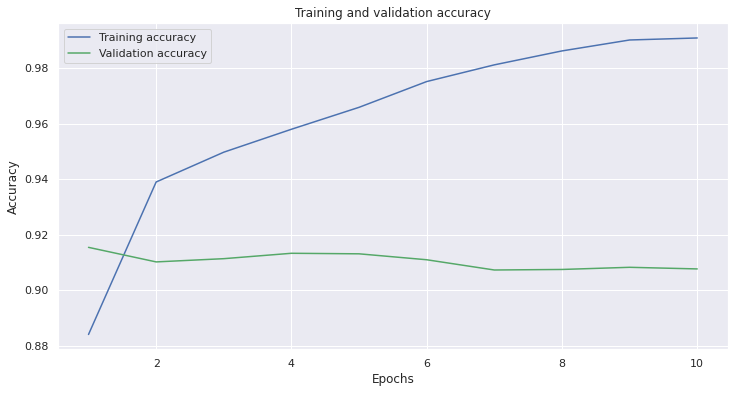

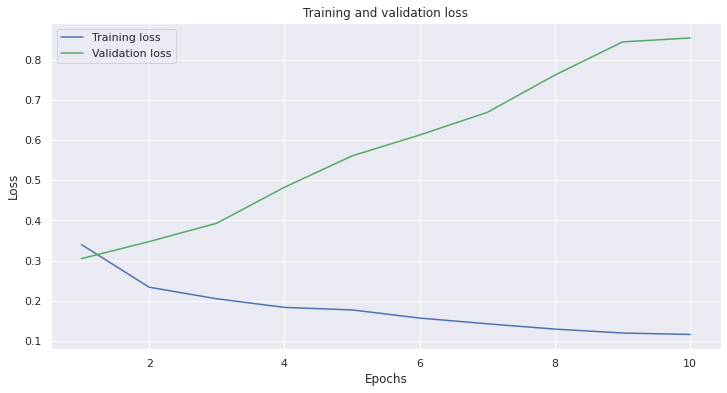

In [124]:
# Let's plot training and validation accuracy as well as loss.
def plot_history(history0):
    accuracy = history0.history['acc']
    val_accuracy = history0.history['val_acc']
    loss = history0.history['loss']
    val_loss = history0.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history0)

In [136]:
# Create callback for early stopping on validation loss.
## Patience = 2 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0, mode ='auto',verbose =1)]

# Train and validate model -val_loss
history = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE,callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1286 - acc: 0.9867 - val_loss: 0.7517 - val_acc: 0.9128
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1214 - acc: 0.9890 - val_loss: 0.8589 - val_acc: 0.9089
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1169 - acc: 0.9908 - val_loss: 0.8813 - val_acc: 0.9108
Epoch 3: early stopping


In [137]:
# Create callback for early stopping on validation loss.
## Patience = 2 and Min Delta = 0.01
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01, mode ='auto',verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1154 - acc: 0.9906 - val_loss: 0.8852 - val_acc: 0.9085
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1145 - acc: 0.9913 - val_loss: 0.9377 - val_acc: 0.9083
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1144 - acc: 0.9909 - val_loss: 0.9407 - val_acc: 0.9098
Epoch 3: early stopping


In [138]:
# Create callback for early stopping on validation loss.
## Patience = 2 and Min Delta = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001, mode ='auto',verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=epoch_no, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1128 - acc: 0.9911 - val_loss: 0.9268 - val_acc: 0.9104
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1131 - acc: 0.9914 - val_loss: 0.9772 - val_acc: 0.9075
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1136 - acc: 0.9908 - val_loss: 0.8731 - val_acc: 0.9104
Epoch 4/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1142 - acc: 0.9902 - val_loss: 0.8806 - val_acc: 0.9116
Epoch 5/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1116 - acc: 0.9910 - val_loss: 0.8886 - val_acc: 0.9079
Epoch 5: early stopping


In [141]:
#create callback for early stopping on validation loss. If the loss does
## Patience = 1 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=0, mode ='auto', verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1057 - acc: 0.9925 - val_loss: 0.8391 - val_acc: 0.9087
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1063 - acc: 0.9921 - val_loss: 0.8135 - val_acc: 0.9077
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1057 - acc: 0.9923 - val_loss: 0.8123 - val_acc: 0.9118
Epoch 4/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1094 - acc: 0.9915 - val_loss: 0.8185 - val_acc: 0.9079
Epoch 4: early stopping


In [142]:
#create callback for early stopping on validation loss. If the loss does
## Patience = 1 and Min Delta = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001, mode ='auto', verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1068 - acc: 0.9919 - val_loss: 0.8081 - val_acc: 0.9120
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1028 - acc: 0.9928 - val_loss: 0.8296 - val_acc: 0.9097
Epoch 2: early stopping


In [145]:
#create callback for early stopping on validation loss. If the loss does
## Patience = 0 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, min_delta=0, mode ='auto', verbose =1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 8s 3ms/step - loss: 0.1045 - acc: 0.9921 - val_loss: 0.8500 - val_acc: 0.9071
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1018 - acc: 0.9930 - val_loss: 0.8612 - val_acc: 0.9089
Epoch 2: early stopping


In [146]:
from tensorflow.keras.callbacks import ModelCheckpoint 

## Patience = 0 and Min Delta = 0.0001
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, min_delta=0.0001, mode ='auto',verbose = 1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1027 - acc: 0.9926 - val_loss: 0.9010 - val_acc: 0.9075
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.1029 - acc: 0.9925 - val_loss: 0.8816 - val_acc: 0.9071
Epoch 2: early stopping


## Testing using Sigmoid

In [97]:
import tensorflow as tf
from tensorflow import keras


# input shape is the vocabulary count used for the movie reviews (10,000 words)
#DROPOUT_RATE = 0.2
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = df_val.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = keras.Sequential()
# Applies Dropout to the input
#model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='sigmoid'))
   # model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.build(input_shape=(2,10000))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_6 (ModuleWra  (2, 64)                  640064    
 pper)                                                           
                                                                 
 module_wrapper_7 (ModuleWra  (2, 1)                   65        
 pper)                                                           
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


In [98]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow_addons.optimizers import AdamW
learning_rate = 2e-5

loss = 'binary_crossentropy'
optimizer = tfa.optimizers.AdamW(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
epoch_no =10 # Follow the baseline set up 

In [99]:
from tensorflow.keras.callbacks import ModelCheckpoint 

## Patience = 2 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0, mode ='auto',verbose = 1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 8s 3ms/step - loss: 7.6664 - acc: 0.5030 - val_loss: 7.6945 - val_acc: 0.5012
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 7.6664 - acc: 0.5030 - val_loss: 7.6945 - val_acc: 0.5012
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 7.6664 - acc: 0.5030 - val_loss: 7.6945 - val_acc: 0.5012
Epoch 3: early stopping


In [100]:
results = model.evaluate(X_test,  y_test, verbose = 1)
print('test loss, test acc:', results)

162/162 [==============================] - 0s 2ms/step - loss: 7.6945 - acc: 0.5012
test loss, test acc: [7.69453239440918, 0.5011632442474365]


## Testing with Dropout rate

In [103]:
# Recommended to apply with drop out rate

import tensorflow as tf
from tensorflow import keras


# input shape is the vocabulary count used for the movie reviews (10,000 words)
DROPOUT_RATE = 0.5 ## Based on the Drop out rate my team had derived 
UNITS = 64
NUM_CLASSES = 2
LAYERS = 2
input_shape = df_val.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = keras.Sequential()
# Applies Dropout to the input
#model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='sigmoid'))
   # model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.build(input_shape=(2,10000))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_10 (ModuleWr  (2, 64)                  640064    
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (2, 1)                   65        
 apper)                                                          
                                                                 
Total params: 640,129
Trainable params: 640,129
Non-trainable params: 0
_________________________________________________________________


In [104]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow_addons.optimizers import AdamW
learning_rate = 2e-5

loss = 'binary_crossentropy'
optimizer = tfa.optimizers.AdamW(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
epoch_no =10 # Follow the baseline set up 

In [105]:
from tensorflow.keras.callbacks import ModelCheckpoint 

## Patience = 2 and Min Delta = 0
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0, mode ='auto',verbose = 1)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/10
2321/2321 [==============================] - 8s 3ms/step - loss: 0.3475 - acc: 0.8731 - val_loss: 0.2746 - val_acc: 0.9071
Epoch 2/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.2317 - acc: 0.9239 - val_loss: 0.2818 - val_acc: 0.9193
Epoch 3/10
2321/2321 [==============================] - 7s 3ms/step - loss: 0.2000 - acc: 0.9346 - val_loss: 0.2900 - val_acc: 0.9166
Epoch 3: early stopping
